In [1]:
import torch
import numpy as np
import pandas as pd
import pygmo

import matplotlib.pyplot as plt
import seaborn as sns

from transvae.snc import SNC 

from scipy.stats import pearsonr

from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.tvae_util import *


import os
import pickle as pkl

In [2]:
from pygmo import hypervolume
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [3]:
SAVE_FIGURES=False

In [4]:
def make_model_name(_prop, model_number, semi_sup_percent):
    
    if   _prop == "bch":
        prop="bch"
    elif _prop == "bc":
        prop="boman-chargepH7p2"
    elif _prop == "b":
        prop="boman"
    elif _prop == "c":
        prop="chargepH7p2"
    elif _prop == "h":
        prop="hydrophobicity"
    
    if (semi_sup_percent==100 or semi_sup_percent=="100"):
        percent = ""
        suffix="dPP64-ZScore"
    elif (semi_sup_percent==0 or semi_sup_percent=="0"):
        percent = ""
        suffix="cdhit90-zScoreNormalized"
    else:
        percent = str(semi_sup_percent)+"-"
        suffix="cdhit90-zScoreNormalized"

    model_name=f"transvae-64-peptides-{prop}-zScoreNormalized-{percent}organized-{suffix}"

    return model_name

In [5]:
def get_boloop_runs(model_name, perc, dim_reduction_method, box_bounds):

    if perc==0 or perc=="0":
        _fname = f"boloop_results_{dim_reduction_method}_neg{box_bounds}to{box_bounds}_{model_name}_log10_mic.pkl"
        with open(f"analysis/{model_name}/boloop_results/{_fname}", 'rb') as f:
            data=pkl.load(f)
        
        runs = [data[f'run_{j}'] for j in range(5)]
    else:
        runs = []
        for i in range(5):
            _fname = f"optimization_results_{dim_reduction_method}_neg{box_bounds}to{box_bounds}_{model_name}_run{i}.pkl"
            _fpath = f"analysis/{model_name}/boloop_results/{_fname}"
            if os.path.exists(_fpath):
                with open(_fpath, "rb") as f:
                    _run=pkl.load(f)
            elif dim_reduction_method=="PCA":
                _fname = f"optimization_results_{model_name}_run{i}.pkl"
                print(f"trying filename: {_fname}")
                _fpath = f"analysis/{model_name}/boloop_results/{_fname}"
                with open(_fpath, "rb") as f:
                    _run=pkl.load(f)
                    
            runs.append( _run )
    
    return runs

b-98
c-98
h-98
bc-98
bch-98


Text(0.5, 1.0, 'projection: PCA | MaskPercent: 98')

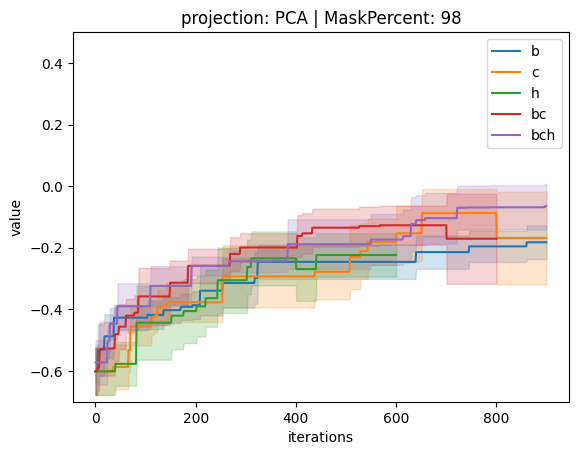

In [50]:
dim_reduction_method="PCA" # options: ['identity', 'PCA']
box_bounds=10 # options: [5,10]
end_point = 1000

properties = ['b','c','h','bc','bch']
_perc = 98
for prop in properties:
    _model_name = make_model_name(prop, "100", _perc)
    
    prop_perc = f"{prop}-{_perc}"
    # results[prop_perc] = {}
    print(prop_perc)
    
    runs = get_boloop_runs(_model_name, _perc, dim_reduction_method, box_bounds)
    
    ### ================ Put into DataFrames ================
    data=pd.DataFrame()
    for i in range(5):
        _data_x = list(range(end_point))#runs[i]['iterations'][:end_point]
        _data_y = runs[i]["best_objective_values"][:end_point]
        if len(_data_y)<end_point:
            _data_y = _data_y + [np.nan]*(end_point-len(_data_y))
        if i==0:
            data['iterations']=_data_x
        data[f"run{i}"]=_data_y

    melted_data = pd.melt(data, id_vars=["iterations"], value_vars=[f"run{i}" for i in range(5)])

    sns.lineplot(data=melted_data, 
             x="iterations",
             y="value", 
             label=prop,
             errorbar='se',
             linestyle="-",#line_style_options[j],
    )
    plt.ylim([-0.7,0.5])

plt.title(f"projection: {dim_reduction_method} | MaskPercent: {_perc}")

In [ ]:
sns.lineplot(data=melted_data, 
             x="iterations",
             y="value", 
             label=str(0),
             errorbar='se',
             linestyle="-",#line_style_options[j],
)
plt.ylim([-0.7,0.5])

In [ ]:

_scores_encountered=[]
for i in range(5):
    _scores_encountered += runs[f"run_{i}"]["candidate_scores"] 

plt.hist(_scores_encountered, color="k", alpha=0.85)

# checking some older runs

In [40]:
bch98_model_name = make_model_name("bch", "100", 98)
old_bch98_boloop_results_dir =  f"analysis/{bch98_model_name}/boloop_results_old/"
os.listdir(old_bch98_boloop_results_dir)

['boloop_results_PCA_neg10to10_transvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_log10_mic.pkl',
 'optimization_results_transvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_run4.pkl',
 'optimization_results_transvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_run2.pkl',
 'optimization_results_transvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_run1.pkl',
 'optimization_results_transvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_run3.pkl',
 'boloop_results_PCAtransvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_log10_mic.pkl',
 'optimization_results_transvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_run0.pkl']

In [33]:
old_bch98_runs = {}
for _f in os.listdir(old_bch98_boloop_results_dir):
    _run_number = _f.split(".")[0][-1]
    with open(old_bch98_boloop_results_dir+_f, 'rb') as fobj:
        _data = pkl.load(fobj)
    old_bch98_runs[_run_number] = _data

In [34]:
old_bch98_runs.keys()

dict_keys(['4', '2', '1', '3', '0'])

(-0.7, 0.5)

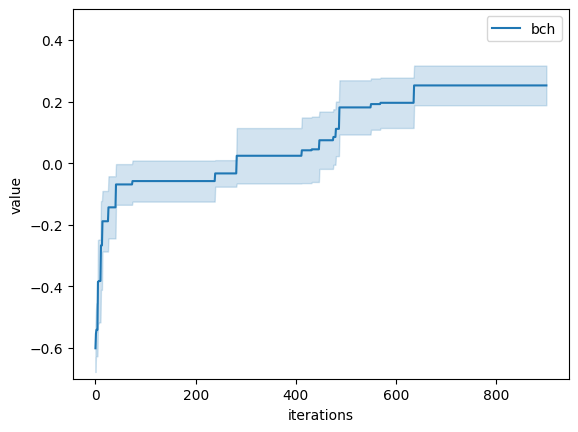

In [36]:

### ================ Put into DataFrames ================
data=pd.DataFrame()
for i in range(5):
    _data_x = list(range(end_point))#runs[i]['iterations'][:end_point]
    _data_y = old_bch98_runs[str(i)]["best_objective_values"][:end_point]

    if len(_data_y)<end_point:
        _data_y = _data_y + [np.nan]*(end_point-len(_data_y))
    if i==0:
        data['iterations']=_data_x
    data[f"run{i}"]=_data_y

melted_data = pd.melt(data, id_vars=["iterations"], value_vars=[f"run{i}" for i in range(5)])

sns.lineplot(data=melted_data, 
         x="iterations",
         y="value", 
         label=prop,
         errorbar='se',
         linestyle="-",#line_style_options[j],
)
plt.ylim([-0.7,0.5])

In [46]:
with open(old_bch98_boloop_results_dir+'boloop_results_PCA_neg10to10_transvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_log10_mic.pkl', 'rb') as fobj:
# with open(old_bch98_boloop_results_dir+'boloop_results_PCAtransvae-64-peptides-bch-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_log10_mic.pkl', 'rb') as fobj:
    runs= pkl.load(fobj)

In [47]:
runs.keys()

dict_keys(['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'params'])

(-0.7, 0.5)

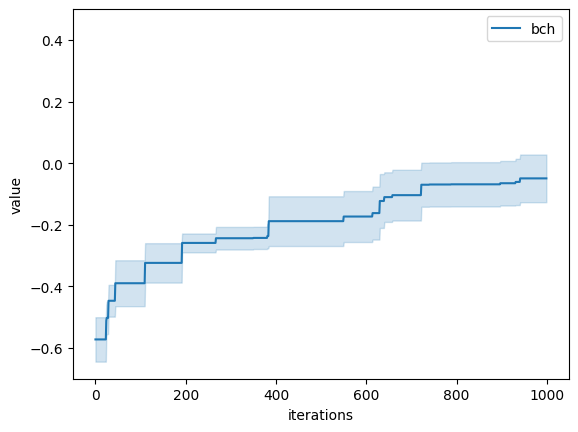

In [48]:

### ================ Put into DataFrames ================
data=pd.DataFrame()
for i in range(5):
    _data_x = list(range(end_point))#runs[i]['iterations'][:end_point]
    _data_y = runs[f"run_{i}"]["best_objective_values"][:end_point]

    if len(_data_y)<end_point:
        _data_y = _data_y + [np.nan]*(end_point-len(_data_y))
    if i==0:
        data['iterations']=_data_x
    data[f"run{i}"]=_data_y

melted_data = pd.melt(data, id_vars=["iterations"], value_vars=[f"run{i}" for i in range(5)])

sns.lineplot(data=melted_data, 
         x="iterations",
         y="value", 
         label=prop,
         errorbar='se',
         linestyle="-",#line_style_options[j],
)
plt.ylim([-0.7,0.5])